# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

     |████████████████████████████████| 1.7 MB 6.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 953 kB 7.5 MB/s            
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.0
    Uninstalling wheel-0.37.0:
      Successfully uninstalled wheel-0.37.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 47.3 MB 77.5 MB/s            
     |████████████████████████████████| 8.6 MB 58.8 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080040 sha256=cc1597b18cbbcbca3b2b5f623b8cdabad695e951086823d959f9a231d524d522
  Stored in directory: /root/.cache/pip/wheels/9f/9e/ac/f24f30e119df73511fde9af8aa747217ac8824e662037ba9a8
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.3.3
    Uninstalling bokeh-2.3.3:
      Successfully uninstalled bokeh-2.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you h

### Setup Kaggle API Key

In [1]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "mariamgado"
kaggle_key = "a3f0b1597663fb202afd7186be717aa0"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
![kaggle6.png](attachment:kaggle6.png)

In [12]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open bike-sharing-demand.zip, bike-sharing-demand.zip.zip or bike-sharing-demand.zip.ZIP.


In [13]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [14]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [15]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [17]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [18]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [19]:
predictor = TabularPredictor(label="count",eval_metric="root_mean_squared_error",learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(train_data=train,time_limit=600,presets="best_quality",)

No path specified. Models will be saved in: "AutogluonModels/ag-20220105_223643/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220105_223643/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 11
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12708.65 MB
	Train Data (Original)  Memory Usage: 1.52 MB (0.0% of avail

[1000]	train_set's rmse: 123.806	valid_set's rmse: 134.369
[2000]	train_set's rmse: 117.412	valid_set's rmse: 133.705


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 123.42	valid_set's rmse: 141.5


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 125.097	valid_set's rmse: 128.797
[2000]	train_set's rmse: 119.003	valid_set's rmse: 127.909
[3000]	train_set's rmse: 114.63	valid_set's rmse: 127.431
[4000]	train_set's rmse: 111.295	valid_set's rmse: 126.943
[5000]	train_set's rmse: 108.576	valid_set's rmse: 126.844
[6000]	train_set's rmse: 106.085	valid_set's rmse: 126.71


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.131	valid_set's rmse: 138.303
[2000]	train_set's rmse: 117.833	valid_set's rmse: 137.535


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.871	valid_set's rmse: 128.052
[2000]	train_set's rmse: 118.547	valid_set's rmse: 127.003
[3000]	train_set's rmse: 114.124	valid_set's rmse: 126.834
[4000]	train_set's rmse: 110.645	valid_set's rmse: 126.694


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.654	valid_set's rmse: 135.095
[2000]	train_set's rmse: 118.764	valid_set's rmse: 133.849
[3000]	train_set's rmse: 114.615	valid_set's rmse: 133.509
[4000]	train_set's rmse: 111.249	valid_set's rmse: 133.472
[5000]	train_set's rmse: 108.455	valid_set's rmse: 133.281


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.01	valid_set's rmse: 139.355
[2000]	train_set's rmse: 117.819	valid_set's rmse: 138.312
[3000]	train_set's rmse: 113.4	valid_set's rmse: 137.886
[4000]	train_set's rmse: 110.032	valid_set's rmse: 137.758


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.47	valid_set's rmse: 135.412


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.18	valid_set's rmse: 137.579
[2000]	train_set's rmse: 117.782	valid_set's rmse: 136.664
[3000]	train_set's rmse: 113.447	valid_set's rmse: 136.246
[4000]	train_set's rmse: 109.982	valid_set's rmse: 136.227


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.641	valid_set's rmse: 132.484


	-134.0883	 = Validation score   (root_mean_squared_error)
	41.27s	 = Training   runtime
	2.32s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 350.23s of the 550.26s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' arg

[1000]	train_set's rmse: 96.0217	valid_set's rmse: 123.249


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 94.7479	valid_set's rmse: 135.635


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.3055	valid_set's rmse: 132.087


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.1635	valid_set's rmse: 131.521


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-132.2864	 = Validation score   (root_mean_squared_error)
	11.84s	 = Training   runtime
	0.48s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 336.38s of the 536.41s of remaining time.
	-118.4567	 = Validation score   (root_mean_squared_error)
	8.06s	 = Training   runtime

### Review AutoGluon's training run with ranking of models that did the best.

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -114.920742       7.262497  543.047213                0.000665           0.354444            3       True         19
1   NeuralNetFastAI_BAG_L2 -115.575381       6.298848  477.480453                0.341404          99.436427            2       True         17
2        LightGBMXT_BAG_L2 -116.367287       6.183960  387.873871                0.226517           9.829845            2       True         12
3          CatBoost_BAG_L2 -116.501367       5.993030  404.096403                0.035587          26.052377            2       True         15
4          LightGBM_BAG_L2 -116.898024       6.038872  385.088454                0.081429           7.044428            2       True         13
5           XGBoost_BAG_L2 -117.443467       6.042247  393.069675         

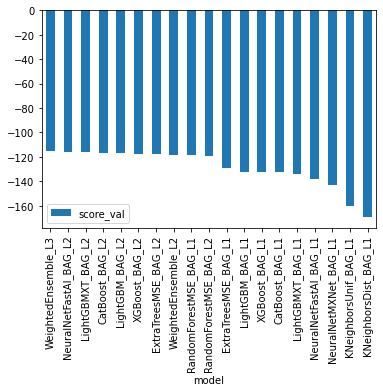

In [21]:
predictor.fit_summary()
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

### Create predictions from test dataset

In [22]:
predictions = predictor.predict(test)
predictions.head()

0    100.739838
1     92.848518
2     92.849640
3    108.967896
4    108.889267
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [23]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      212.096252
std       129.871292
min        -5.185597
25%       106.492363
50%       194.589584
75%       297.853699
max       660.371704
Name: count, dtype: float64

In [25]:
# Set them to zero
predictions[predictions < 0] = 0
predictions.describe()

count    6493.000000
mean      212.097656
std       129.868958
min         0.000000
25%       106.492363
50%       194.589584
75%       297.853699
max       660.371704
Name: count, dtype: float64

### Set predictions to submission dataframe, save, and submit

In [26]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [27]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:01<00:00, 109kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [28]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2022-01-05 22:50:36  first raw submission               complete  1.39472      1.39472       
submission_new_hpo.csv       2022-01-05 21:45:20  new features with hyperparameters  complete  1.31510      1.31510       
submission_new_features.csv  2022-01-05 21:31:12  new features                       complete  1.42767      1.42767       


#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7e2757e50>,
      dtype=object)

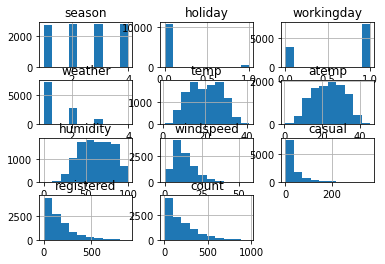

In [29]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [30]:
# create a new feature
train["season"] = train["season"]
train["weather"]=train["weather"]
test["season"] = test["season"]
test["weather"]=test["weather"]
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [31]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [32]:
train['datetime'] = pd.to_datetime(train[ 'datetime'])
train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(3), int64(9)
memory usage: 

In [33]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7e50d2250>,
      dtype=object)

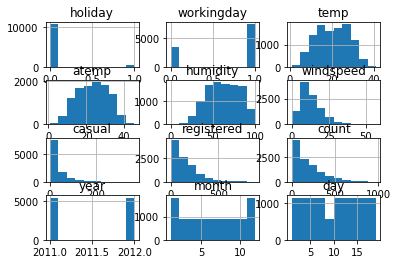

In [34]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [35]:
predictor_new_features = TabularPredictor(label="count",eval_metric="root_mean_squared_error",learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(train_data=train,time_limit=800,presets="best_quality",)

No path specified. Models will be saved in: "AutogluonModels/ag-20220105_225121/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 800s
AutoGluon will save models to "AutogluonModels/ag-20220105_225121/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12235.87 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.0% of avail

[1000]	train_set's rmse: 113.993	valid_set's rmse: 130.014
[2000]	train_set's rmse: 104.698	valid_set's rmse: 129.399


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.9	valid_set's rmse: 125.982


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 113.663	valid_set's rmse: 135.791
[2000]	train_set's rmse: 104.598	valid_set's rmse: 134.163
[3000]	train_set's rmse: 98.5016	valid_set's rmse: 133.879
[4000]	train_set's rmse: 93.6273	valid_set's rmse: 133.595
[5000]	train_set's rmse: 89.7091	valid_set's rmse: 133.563


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.778	valid_set's rmse: 124.059
[2000]	train_set's rmse: 105.23	valid_set's rmse: 123.652


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.058	valid_set's rmse: 132.034
[2000]	train_set's rmse: 104.831	valid_set's rmse: 130.944
[3000]	train_set's rmse: 98.5704	valid_set's rmse: 130.287
[4000]	train_set's rmse: 93.8403	valid_set's rmse: 129.976
[5000]	train_set's rmse: 90.0564	valid_set's rmse: 129.731


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 113.885	valid_set's rmse: 135.902
[2000]	train_set's rmse: 104.745	valid_set's rmse: 134.457
[3000]	train_set's rmse: 98.4633	valid_set's rmse: 134.051
[4000]	train_set's rmse: 93.5421	valid_set's rmse: 133.928


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.247	valid_set's rmse: 132.106
[2000]	train_set's rmse: 104.952	valid_set's rmse: 131.12
[3000]	train_set's rmse: 98.5967	valid_set's rmse: 130.903
[4000]	train_set's rmse: 93.8099	valid_set's rmse: 130.869


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 113.595	valid_set's rmse: 134.693
[2000]	train_set's rmse: 104.28	valid_set's rmse: 134.041
[3000]	train_set's rmse: 97.9981	valid_set's rmse: 134.061


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.288	valid_set's rmse: 129.864
[2000]	train_set's rmse: 104.912	valid_set's rmse: 129.067
[3000]	train_set's rmse: 98.4816	valid_set's rmse: 128.8
[4000]	train_set's rmse: 93.7508	valid_set's rmse: 128.465


	-130.9425	 = Validation score   (root_mean_squared_error)
	44.43s	 = Training   runtime
	2.7s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 479.73s of the 746.39s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argu

[1000]	train_set's rmse: 90.1843	valid_set's rmse: 133.707


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.6414	valid_set's rmse: 129.431


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.6573	valid_set's rmse: 134.318


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 91.2019	valid_set's rmse: 130.992


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.492	valid_set's rmse: 128.95


	-130.6938	 = Validation score   (root_mean_squared_error)
	15.0s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 462.29s of the 728.95s of remaining time.
	-117.3606	 = Validation score   (root_mean_squared_error)
	9.55s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 451.35s of the 718.01s of remaining time.
	-132.4003	 = Validation score   (root_mean_squared_error)
	131.34s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 319.78s of the 586.44s of remaining time.
	-125.7347	 = Validation score   (root_mean_squared_error)
	4.04s	 = Training   runtime
	0.44s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 314.13s of the 580.79s of remaining time.
	-134.832	 = Validation score   (root_mean_squared_error)
	130.19s	 = Training   runtime
	0.36s	 = Valid

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -113.672773       8.775904  720.418325                0.000642           0.332146            3       True         19
1   NeuralNetFastAI_BAG_L2 -114.270164       7.778555  634.488361                0.410967         126.103840            2       True         17
2        LightGBMXT_BAG_L2 -115.376829       7.614677  518.880894                0.247089          10.496373            2       True         12
3          CatBoost_BAG_L2 -115.521575       7.441304  567.260399                0.073716          58.875878            2       True         15
4          LightGBM_BAG_L2 -116.095306       7.504196  516.346660                0.136607           7.962139            2       True         13
5     ExtraTreesMSE_BAG_L2 -116.144543       7.906883  516.647949         

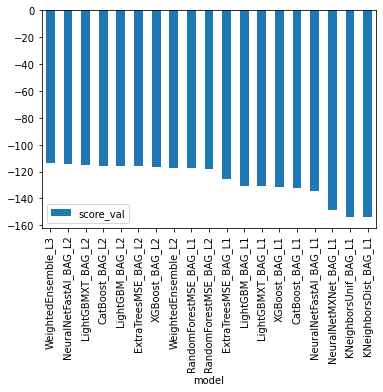

In [36]:
predictor_new_features.fit_summary()
predictor_new_features.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [37]:
# Remember to set all negative values to zero
predictions_new_features =predictor_new_features.predict(test)
predictions_new_features[predictions_new_features < 0] = 0
predictions_new_features.describe()

count    6493.000000
mean      217.621933
std       128.873810
min         0.000000
25%       116.907936
50%       191.017517
75%       300.626556
max       650.002319
Name: count, dtype: float64

In [38]:
# Same submitting predictions
submission_new_features = pd.read_csv("sampleSubmission.csv")
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [39]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:01<00:00, 136kB/s]
Successfully submitted to Bike Sharing Demand

In [40]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2022-01-05 23:06:05  new features                       complete  1.42545      1.42545       
submission.csv               2022-01-05 22:50:36  first raw submission               complete  1.39472      1.39472       
submission_new_hpo.csv       2022-01-05 21:45:20  new features with hyperparameters  complete  1.31510      1.31510       


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [41]:
predictor_new_hpo = TabularPredictor(label="count",eval_metric="root_mean_squared_error",learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(train_data=train,time_limit=1000,presets="best_quality",hyperparameters="multimodal",hyperparameter_tune_kwargs="bayesopt")

No path specified. Models will be saved in: "AutogluonModels/ag-20220105_230820/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "AutogluonModels/ag-20220105_230820/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12106.29 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.0% of avai

[1000]	train_set's rmse: 120.434	valid_set's rmse: 132.562


	Ran out of time, early stopping on iteration 1608. Best iteration is:
	[1608]	train_set's rmse: 114.523	valid_set's rmse: 131.094
	Time limit exceeded
Fitted model: LightGBM_BAG_L1/T0 ...
	-129.1582	 = Validation score   (root_mean_squared_error)
	1.24s	 = Training   runtime
	0.05s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T1 ...
	-129.9348	 = Validation score   (root_mean_squared_error)
	2.17s	 = Training   runtime
	0.09s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-131.0937	 = Validation score   (root_mean_squared_error)
	2.32s	 = Training   runtime
	0.13s	 = Validation runtime
Hyperparameter tuning model: LightGBMXT_BAG_L1 ...
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Ligh

[1000]	train_set's rmse: 113.911	valid_set's rmse: 130.203
[2000]	train_set's rmse: 104.436	valid_set's rmse: 129.475
[3000]	train_set's rmse: 98.1229	valid_set's rmse: 129.362
[4000]	train_set's rmse: 93.2776	valid_set's rmse: 129.372


	Time limit exceeded
Fitted model: LightGBMXT_BAG_L1/T0 ...
	-129.2296	 = Validation score   (root_mean_squared_error)
	5.19s	 = Training   runtime
	0.31s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ...
	Time limit exceeded
Fitted model: CatBoost_BAG_L1/T0 ...
	-131.8537	 = Validation score   (root_mean_squared_error)
	9.33s	 = Training   runtime
	0.01s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L1 ...
	Time limit exceeded
Fitted model: XGBoost_BAG_L1/T0 ...
	-129.8473	 = Validation score   (root_mean_squared_error)
	2.02s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: XGBoost_BAG_L1/T1 ...
	-130.7767	 = Validation score   (root_mean_squared_error)
	4.42s	 = Training   runtime
	0.05s	 = Validation runtime
Hyperparameter tuning model: NeuralNetMXNet_BAG_L1 ...
	Ran out of time, stopping training early. (Stopping on epoch 3)
	Time limit exceeded
Fitted model: NeuralNetMXNet_BAG_L1/T0 ...
	-211.6738	 = Validation score   (root_m

[1000]	train_set's rmse: 90.1843	valid_set's rmse: 133.707


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.6414	valid_set's rmse: 129.431


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.6573	valid_set's rmse: 134.318


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 91.2019	valid_set's rmse: 130.992


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.492	valid_set's rmse: 128.95


	-130.6938	 = Validation score   (root_mean_squared_error)
	15.03s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: LightGBM_BAG_L1/T1 ... Training model for up to 608.72s of the 942.05s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' 

[1000]	train_set's rmse: 90.1843	valid_set's rmse: 133.707


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.6414	valid_set's rmse: 129.431


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.6573	valid_set's rmse: 134.318


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 91.2019	valid_set's rmse: 130.992


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.492	valid_set's rmse: 128.95


	-130.7708	 = Validation score   (root_mean_squared_error)
	16.04s	 = Training   runtime
	0.74s	 = Validation runtime
Fitting model: LightGBM_BAG_L1/T2 ... Training model for up to 592.61s of the 925.94s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' 

[1000]	train_set's rmse: 90.1843	valid_set's rmse: 133.707


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.6414	valid_set's rmse: 129.431


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.6573	valid_set's rmse: 134.318


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 91.2019	valid_set's rmse: 130.992


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 90.492	valid_set's rmse: 128.95


	-130.8865	 = Validation score   (root_mean_squared_error)
	16.09s	 = Training   runtime
	0.78s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1/T0 ... Training model for up to 576.57s of the 909.89s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.9	valid_set's rmse: 125.982


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 113.663	valid_set's rmse: 135.791
[2000]	train_set's rmse: 104.598	valid_set's rmse: 134.163
[3000]	train_set's rmse: 98.5016	valid_set's rmse: 133.879
[4000]	train_set's rmse: 93.6273	valid_set's rmse: 133.595
[5000]	train_set's rmse: 89.7091	valid_set's rmse: 133.563


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.778	valid_set's rmse: 124.059
[2000]	train_set's rmse: 105.23	valid_set's rmse: 123.652


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.058	valid_set's rmse: 132.034
[2000]	train_set's rmse: 104.831	valid_set's rmse: 130.944
[3000]	train_set's rmse: 98.5704	valid_set's rmse: 130.287
[4000]	train_set's rmse: 93.8403	valid_set's rmse: 129.976
[5000]	train_set's rmse: 90.0564	valid_set's rmse: 129.731


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 113.885	valid_set's rmse: 135.902
[2000]	train_set's rmse: 104.745	valid_set's rmse: 134.457
[3000]	train_set's rmse: 98.4633	valid_set's rmse: 134.051
[4000]	train_set's rmse: 93.5421	valid_set's rmse: 133.928


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.247	valid_set's rmse: 132.106
[2000]	train_set's rmse: 104.952	valid_set's rmse: 131.12
[3000]	train_set's rmse: 98.5967	valid_set's rmse: 130.903
[4000]	train_set's rmse: 93.8099	valid_set's rmse: 130.869


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 113.595	valid_set's rmse: 134.693
[2000]	train_set's rmse: 104.28	valid_set's rmse: 134.041
[3000]	train_set's rmse: 97.9981	valid_set's rmse: 134.061


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 114.288	valid_set's rmse: 129.864
[2000]	train_set's rmse: 104.912	valid_set's rmse: 129.067
[3000]	train_set's rmse: 98.4816	valid_set's rmse: 128.8
[4000]	train_set's rmse: 93.7508	valid_set's rmse: 128.465


	-130.9335	 = Validation score   (root_mean_squared_error)
	46.37s	 = Training   runtime
	2.84s	 = Validation runtime
Fitting model: CatBoost_BAG_L1/T0 ... Training model for up to 527.75s of the 861.07s of remaining time.
	-132.4569	 = Validation score   (root_mean_squared_error)
	126.42s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: XGBoost_BAG_L1/T0 ... Training model for up to 410.47s of the 743.8s of remaining time.
	-131.5809	 = Validation score   (root_mean_squared_error)
	15.38s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: XGBoost_BAG_L1/T1 ... Training model for up to 395.9s of the 729.23s of remaining time.
	-131.6729	 = Validation score   (root_mean_squared_error)
	17.95s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L1/T0 ... Training model for up to 381.14s of the 714.46s of remaining time.
	Ran out of time, stopping training early. (Stopping on epoch 31)
	Ran out of time, stopping training ear

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       LightGBMLarge_BAG_L2 -124.152218       7.622911  623.277847                0.013889           1.399028            2       True         22
1       LightGBMLarge_BAG_L1 -128.618310       0.049760    2.068435                0.049760           2.068435            1       True          9
2        WeightedEnsemble_L3 -128.630694       8.068372  687.034695                0.000636           0.418641            3       True         23
3       LightGBMXT_BAG_L2/T1 -128.793990       7.751673  628.208838                0.142650           6.330019            2       True         15
4       LightGBMXT_BAG_L2/T0 -128.809632       7.745554  627.902991                0.136531           6.024172            2       True         14
5       LightGBMXT_BAG_L2/T2 -128.816089       7.765879  628.7

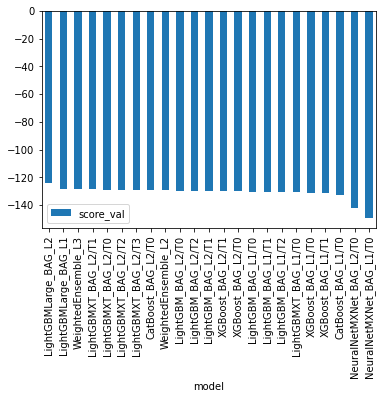

In [42]:
predictor_new_hpo.fit_summary()
predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [43]:
# Remember to set all negative values to zero
predictor_new_hpo =predictor_new_hpo.predict(test)
predictor_new_hpo[predictor_new_hpo < 0] = 0
predictor_new_hpo.describe()

count    6493.000000
mean      195.453995
std       127.848785
min        28.234989
25%        96.082024
50%       160.911392
75%       272.959900
max       603.307678
Name: count, dtype: float64

In [44]:
# Same submitting predictions
submission_new_hpo= pd.read_csv("sampleSubmission.csv")
submission_new_hpo["count"] = predictor_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [45]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:02<00:00, 88.9kB/s]
Successfully submitted to Bike Sharing Demand

In [46]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-01-05 23:27:21  new features with hyperparameters  complete  1.31040      1.31040       
submission_new_features.csv  2022-01-05 23:06:05  new features                       complete  1.42545      1.42545       
submission.csv               2022-01-05 22:50:36  first raw submission               complete  1.39472      1.39472       


#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

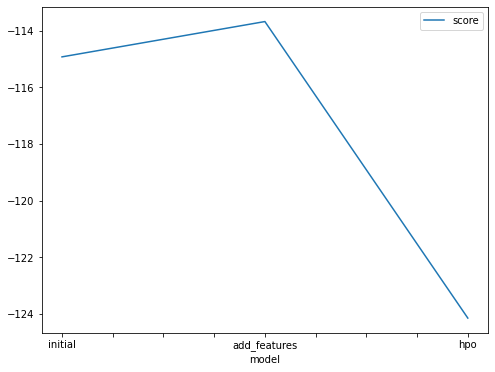

In [47]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [ -114.920742, -113.672773, -124.152218]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

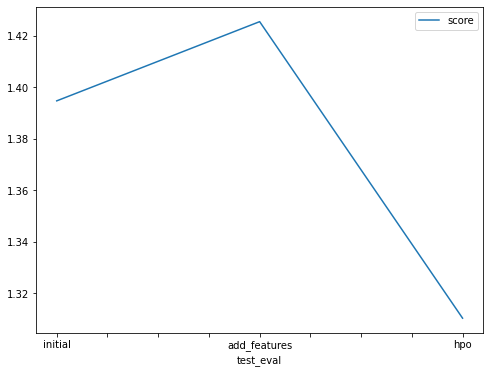

In [48]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.39472, 1.42545, 1.31040]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [49]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [600, 800, 1000],
    "hpo2": ['defult', 'defult', 'multimodal'],
    "hpo3": ['defult', 'defult', 'bayesopt'],
    "score": [1.39472, 1.42545, 1.31040]
})

,model,hpo1,hpo2,hpo3,score
0,initial,600,defult,defult,1.39472
1,add_features,800,defult,defult,1.42545
2,hpo,1000,multimodal,bayesopt,1.31040
